
## Assignment Details
**Assignment**: 2 
    
**Apache Kafka – Spark Integration**

**Group**: SPA Assignment Group 15 

**Group Members**:

| NAME      | BITS ID |
|---:|----:|
| Bala Kavin Pon |   2018AC04531 |
| Venkataramanan K |  2018AC04529 |
| Sonia Mawandia | 2018AC04551 |

**GitHub Link** - https://github.com/Data-Citadel/SPA-Assignment2


## Probelm Statement
 - Marketing team wanted to measure the impact of a campagin on set of customers with in 100m radius before applying to over all custimers 
 - Write a kafka producer to simulate customers location 
 - Plan a marketting campagin based on the customer location and profile 
 - Pre - process the streaming data and indentify the customers and apply the promotion based on customers attributes


## Initial Setup
-------

#### Install Kafka:
```
$brew cask install java
$brew install kafka
```

#### Install Anaconda :
```
brew install --cask anaconda
```

#### Set the environment varaibles in terminal

```
export PATH="/usr/local/anaconda3/bin:$PATH"
export JAVA_HOME=$(/usr/libexec/java_home -v 1.8)
export PATH=$PATH:$JAVA_HOME/bin
```

#### Install kafka-python & Pyspark
```
python -m pip install kafka-python “pyspark==2.4.7”
```
#### Start Zookeeper
```
zookeeper-server-start /usr/local/etc/kafka/zookeeper.properties
```
#### Start Kafka Server
```
kafka-server-start /usr/local/etc/kafka/server.properties
```

#### Create Needed kafka topics
```
# for customer location tracking
kafka-topics --create --zookeeper localhost:2181 --replication-factor 1 --partitions 1 --topic mymall_cust_topic

# To publish promo to down stream systems 
kafka-topics --create --zookeeper localhost:2181 --replication-factor 1 --partitions 1 --topic mymall_promo_topic
```

## Excercise 1:
--------
Write a custom code that will mimic the movement of the customers and make it available in appropriate format to a Kafka Topic
     
#### Assumptions
 - 200 customer was taken as super set. 
 - To mimic the customers who are online, of the 200, randomly 40 t0 50 customers will be picked and locations will be assinged in 10 point radius from mall. 
 
     radius  - distance of the customer from mall 
                [0 - 2] - with in mall
                [3 - 5] - very near to mall
                [6 - 7] - near to mall
                [8 - 10] - away from mall
                
 - Picked customer with radius info will be published in the kafka topic as JSON entries
 - Above steps will be repeated on one min interval 

### producer.py
  Source code attached sepreately

In [32]:
import pandas as pd
import random
import json
import time
from kafka import KafkaProducer

class Rand_Customer_Producer:

    '''
        bootstrap_servers - bootstap server name 
        sample_range - Range of number of customer need to drwan from total set
        radius  - distance of the customer from shop 
                [0 - 2] - with in mall
                [3 - 5] - very near to mall
                [6 - 7] - near to mall
                [8 - 10] - away from mall
        total_customers - total set we wanted to consider
    '''

    def __init__(self,bootstrap_servers,sample_range,radius,total_customers):
        self.sample_range = sample_range
        self.radius = radius
        self.total_customers = total_customers
        self. producer = self._get_kafka_producer(bootstrap_servers)

    def _get_kafka_producer(self,bootstrap_servers):
        # create kafka producer with json value serializer 
        serializer = lambda v: json.dumps(v).encode('utf-8')
        producer = KafkaProducer(bootstrap_servers=bootstrap_servers,value_serializer= serializer)
        print("Producer running")
        return producer


    def _generateRamdomCustomer(self,sample_size=10,radius=10,total_size=200):
        
        cust_list = []
        #Create total setof customers
        total_set = range(1,total_size)

        #select random n customer from total
        selected_cust = random.sample(total_set,sample_size)

        #add radius to customer
        for i in selected_cust:
            cust_list.append((i,random.randrange(0,radius)))
        
        return cust_list

    def generate_and_publish_msg(self,topic_name):
        # pick the number of custer we need to draw from the range given
        size=random.choice(self.sample_range)
        
        #generate customer list with radius
        customers = self._generateRamdomCustomer(sample_size=size,radius= self.radius, total_size =self.total_customers)
        
        # publish the customer with distance in kafka topic
        for customer in customers:
            self.producer.send( topic_name, {'id': customer[0], 'rad': customer[1]})
        self.producer.flush()

    def send_msg_in_loop(self, topic_name, interval=1, times=30):
        # iterate for every 1 min (Interval) for next 30 times
        for i in range(0,30):
            print(f'publishing for ->{i} iteration')
            self.generate_and_publish_msg(topic_name)
            time.sleep(interval*60) # 

        

if __name__ == "__main__":
    bootstrap_servers = 'localhost:9092'
    topic_name = "mymall_cust_topic"
    total_customers = 200
    sample_range = range(40, 50)
    radius = 10

    producer = Rand_Customer_Producer(bootstrap_servers=bootstrap_servers,
             sample_range=sample_range,
             radius=radius,
             total_customers=total_customers)
    # time in mins
    producer.send_msg_in_loop(topic_name, 1 , 20)
    

### To Run the Producer.py 

```
python producer.py
```

#### View sample message in topic
```
kafka-console-consumer --bootstrap-server localhost:9092 --topic mymall_cust_topic  --from-beginning
```


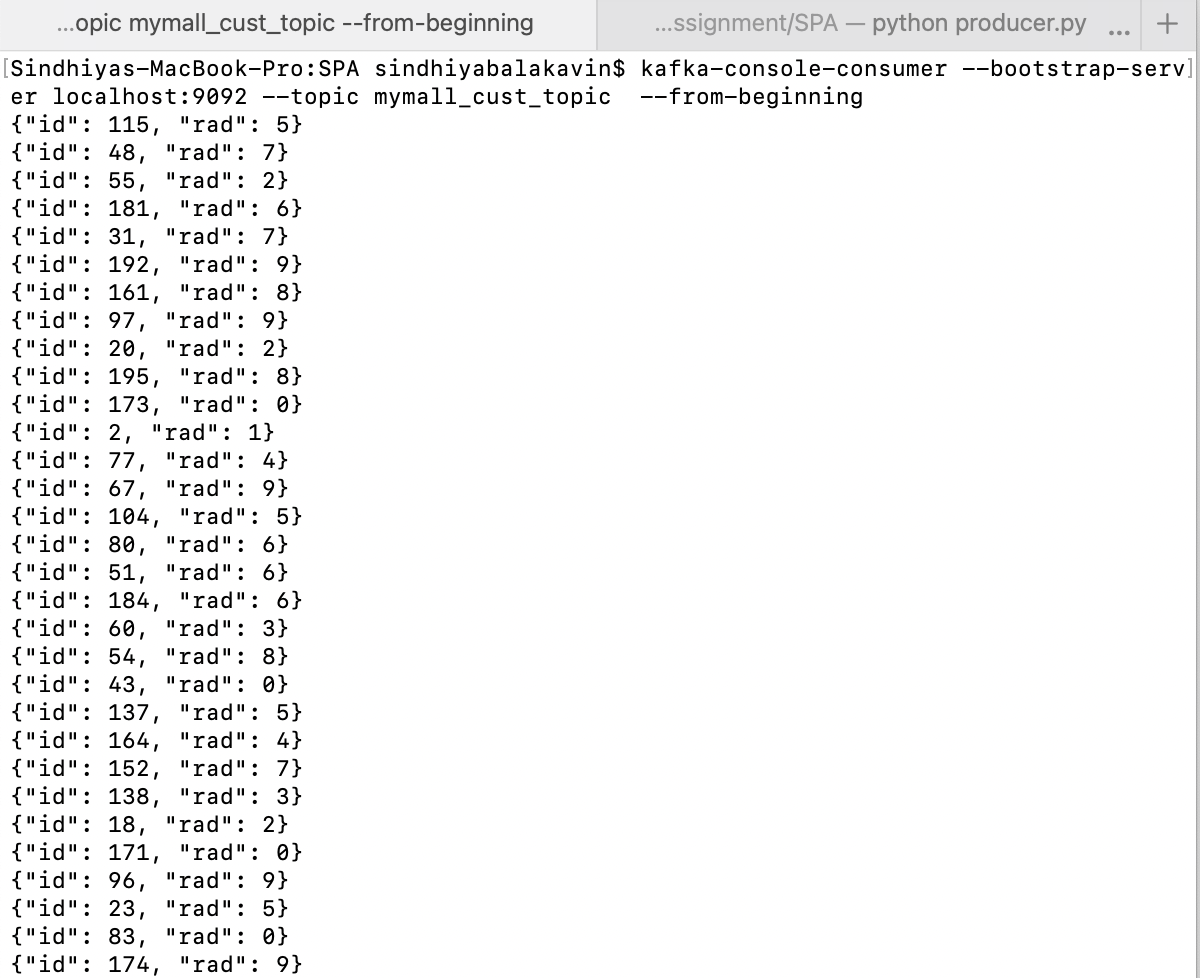

In [13]:
# To display the sample output screenshot
from IPython.display import Image
Image(filename='Screenshot 2021-01-10 at 4.44.33 PM.png') 

## Excercise 2: 
----


Now I'm wearing the hat of analyst. 

Perfrom bleow things:
 - Explore the dataset 
 - Formulate the Promo / Offers 
 - Decide on the pre-processing to be done. 



In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

### Load My Mall Dataset

In [33]:
cust_details=pd.read_excel('./MyMall-DataSet.xlsx')

In [34]:
cust_details.head(3)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6


In [35]:
#Renaming columns just to avoid probles due to sapce and special charectors
cust_details.columns = ['cust_id','gender','age','annual_income','spending_score']

### Finding Dstribution of 
  - Age 
  - Annual Income 
  - Spending Score 

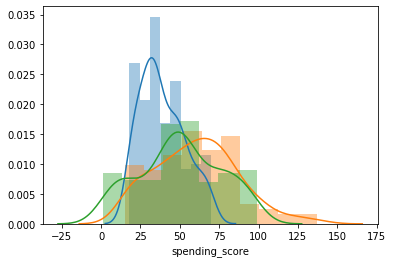

In [36]:
sns.distplot(cust_details['age'])
sns.distplot(cust_details['annual_income'])
sns.distplot(cust_details['spending_score'])

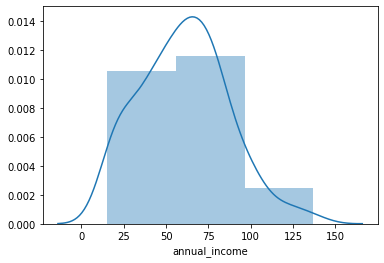

In [37]:
# Anumal Income - convert numeric to categorical (High, Medium, Low)
sns.distplot(cust_details['annual_income'], bins=3)

In [38]:
bins = [0, 50, 80, np.inf]
names = ['Low', 'Medium', 'High']
cust_details['annual_income_cat'] = pd.cut(cust_details['annual_income'], bins, labels=names)

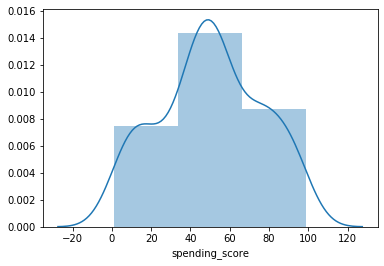

In [39]:
# Spending Score - convert numeric to categorical (High, Medium, Low)
sns.distplot(cust_details['spending_score'], bins=3)

In [40]:
bins = [0, 40, 60, np.inf]
names = ['Low', 'Medium', 'High']
cust_details['spending_score_cat'] = pd.cut(cust_details['spending_score'], bins, labels=names)

In [41]:
cust_details.head(3)

,cust_id,gender,age,annual_income,spending_score,annual_income_cat,spending_score_cat
0,1,Male,19,15,39,Low,Low
1,2,Male,21,15,81,Low,High
2,3,Female,20,16,6,Low,Low


In [ ]:
# To convert pandas dataframe to spark dataframe
cust_dim = spark.createDataFrame(cust_details)

### Promo/Offer - definition and assumption
 
 #### Featuers To Be Dervied
 
 ##### From Stream Data : 
  - Feature 1 - is he/she with in mall ?
  - Feature 2 - is near to mall ?
  - Feature 3 - is he/she spending more time in mall ?
  
 ##### From Data Set : 
 
  - Feature 4 - Age 
  - Feature 5 - Gender 
  - Feature 6 - Annual Income
  - Feature 7 - Spending Capacity
 
 
 #### 5 promo's will be introduced 
 
 |Promo Name| Promo Desc | Condition | 
 |----:|-----:|------:|
 | PROMO 1 | Flat 20% discount on All products | when_near_to_mall and annual_income > 30 |
 | PROMO 2 | Upto 30% discount on Electronics |  for Male's within mall |
 | PROMO 3 | Flat 30% woman clotings | for Female's with age >= 15  |
 | PROMO 4 | Upto 40% on Games | Customers_spending_more_time_in_mall |
 | PROMO 5 | Flat 10% New Arrivals | spending_score = High |

In [10]:
# dict of promo_name and condition 
promo_dict = {
      "PROMO 1 - Flat 20% discount on All products*" : " is_near_to_mall = 1 and annual_income > 30 ",
      "PROMO 2 - Upto 30% discount on Electronics " : " gender='Male' and is_within_mall = 1 " ,
      "PROMO 3 - Flat 30% woman clotings" : " gender = 'Female' and age >= 15 ",
      "PROMO 4 - Upto 40% on Games" : " spending_more_time_in_mall = 1 " ,
      "PROMO 5 - Flat 10% New Arrivals" : " spending_score_cat = 'High' ",
 }

## Excercise 3:
------

#### Start pyspark cli to work interactively 
```
pyspark --packages org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.7
```

#### To run as spark streaming job 
```
spark-submit --packages org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.7 ./SparkStreaming.py
```


### 3.1 Read the kafka stream in pyspark

In [ ]:
# Read data from kafka topic and 
df = spark.readStream \
        .format("kafka") \
        .option("kafka.bootstrap.servers", "localhost:9092") \
        .option("subscribe", "mymall_cust_topic") \
        .option("startingOffsets", "earliest") \
        .load()

 ### 3.2 Preproces the stream data

In [ ]:
  
# Preprocessing 
# Extract the JSON values and split that json data in columns 
value_df = df.selectExpr("CAST(value AS STRING)","timestamp")
schema = StructType([
   StructField("id", IntegerType(), True),
   StructField("rad", IntegerType(), True)])
value_df = value_df.select(from_json(col("value"), schema).alias("data"),col('timestamp')).select("data.*","timestamp")

### 3.3 Group the stream data based on sliding window and customer id and compute 
  - min distance 
  - average distance 
  
of the customer from mall 

In [ ]:
# Group the stream data based on sliding window and customer id
# and compute the min distance and average distance of the customer from mall 
cust_stream_df = value_df.groupBy(
      window(value_df.timestamp, "5 minutes", "5 minutes"),
      value_df.id
      ).agg(
            min("rad").alias("distance"),
            avg("rad").alias('average_distance'),
            max("timestamp").alias('max_time')
            )

### 3.4 Based on distance and average distance, compute below columns
   1. is he/she with in mall ?
   2. is near to mall ?
   3. is he/she spending more time in mall ?

In [ ]:
cust_stream_df = cust_stream_df.selectExpr(
                  "id as cust_id",
                  "case when distance < 3 then 1 else 0 end as is_within_mall",
                  "case when distance between 3 and 6 then 1 else 0 end as is_near_to_mall",
                  "case when ((average_distance - distance) between 0.5 and 1.5) and average_distance < 4 then 1 else 0 end as spending_more_time_in_mall",
                  "max_time"
            )

### 3.5 Filter the stream data and join with static customer profile dataset

In [ ]:
cust_stream_df = cust_stream_df.filter((col("is_near_to_mall") == 1) | (col("is_within_mall") ==1) )
cust_out_df = cust_stream_df.join(cust_dim, "cust_id")

### 3.6 Apply the promocode 

In [ ]:
expression = " CASE "
for promo,condition in promo_dict.items():
      expression = expression + " WHEN "+condition +" THEN '"+ promo+ "' "

expression = expression + " ELSE 'NA' END as promo"

# Apply prod condition on stream dataframe
cust_out_df = cust_out_df.selectExpr(expression, "cust_id")


### 3.7 To display the stream on console 

In [ ]:
cust_out_df.writeStream \
      .format("console") \
      .outputMode("complete") \
      .start() \
      .awaitTermination()

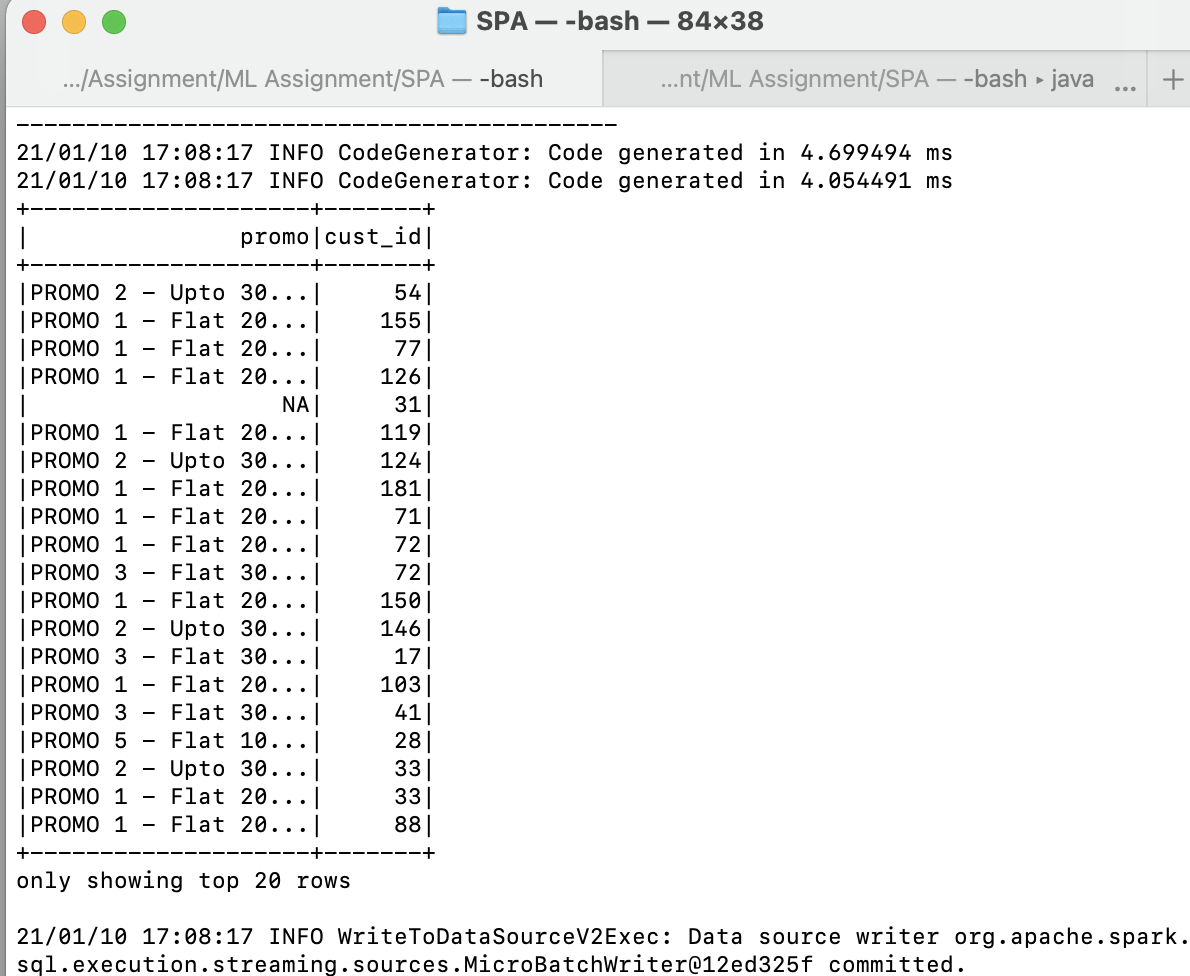

In [16]:
# To display the sample output screenshot
from IPython.display import Image
Image(filename='Screenshot 2021-01-10 at 5.11.58 PM.png') 

### 3.8 Write the promo/offer on a kafka stream 

In [ ]:
ds = cust_out_df \
  .selectExpr("CAST(cust_id AS STRING) as key", "CAST(promo AS STRING) as value") \
  .writeStream \
  .format("kafka") \
  .outputMode("update") \
  .option("kafka.bootstrap.servers", "localhost:9092") \
  .option("topic", "mymall_promo_topic") \
  .option("checkpointLocation", "/tmp/checkpoint" ) \
  .start() \
  .awaitTermination()

#### To View the output stream 
```
kafka-console-consumer --bootstrap-server localhost:9092 --topic mymall_promo_topic --from-beginning --property print.key=true
```

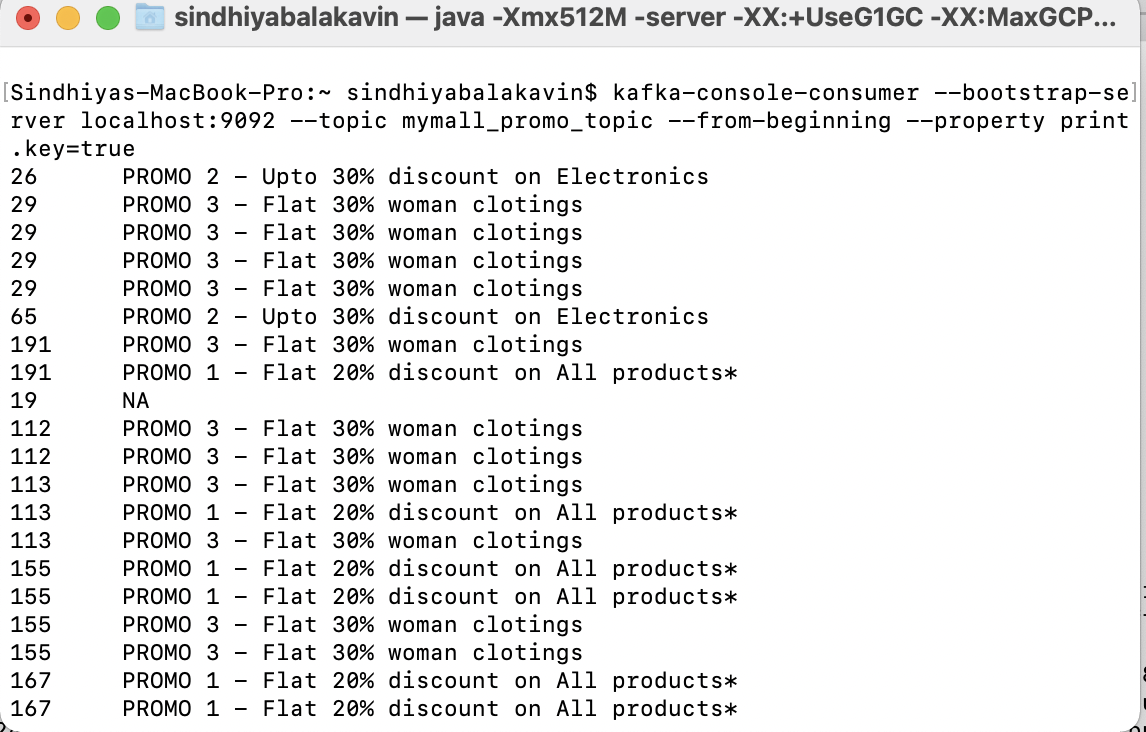

In [17]:
# To display the sample output screenshot
from IPython.display import Image
Image(filename='Screenshot 2021-01-10 at 7.37.22 PM.png') 

## SparkStreaming.py 
Overall Code for spark execution

In [ ]:
import pandas as pd
import numpy as np
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils

spark = SparkSession.builder \
    .master("local") \
    .appName("MyMallStreamingApp") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

######################################
# Processing the customer profile data
######################################

#Loading the dataset as pandas dataframe
cust_details=pd.read_excel('./MyMall-DataSet.xlsx')

# Renaming columns just to avoid probles due to sapce and special charectors
cust_details.columns = ['cust_id','gender','age','annual_income','spending_score']

# Columns are explored using Histograms in jupyter based on that bins are formulated
# Spending capacity - convert numeric to categorical (High, Medium, Low)
bins = [0, 40, 60, np.inf]
names = ['Low', 'Medium', 'High']
cust_details['spending_score_cat'] = pd.cut(cust_details['spending_score'], bins, labels=names)

# Annual Income - convert numeric to categorical (High, Medium, Low)
bins = [0, 50, 80, np.inf]
names = ['Low', 'Medium', 'High']
cust_details['annual_income_cat'] = pd.cut(cust_details['annual_income'], bins, labels=names)

#convert panads dataframe to spark dataframe 
cust_dim = spark.createDataFrame(cust_details)

###############################################
# Processing the streaming data from kafka topic
##############################################

# Read data from kafka topic and 
df = spark.readStream \
        .format("kafka") \
        .option("kafka.bootstrap.servers", "localhost:9092") \
        .option("subscribe", "mymall_cust_topic") \
        .option("startingOffsets", "earliest") \
        .load()

# Preprocessing 
# Extract the JSON values and split that json data in columns 
value_df = df.selectExpr("CAST(value AS STRING)","timestamp")
schema = StructType([
   StructField("id", IntegerType(), True),
   StructField("rad", IntegerType(), True)])
value_df = value_df.select(from_json(col("value"), schema).alias("data"),col('timestamp')).select("data.*","timestamp")

# Group the stream data based on sliding window and customer id
# and compute the min distance and average distance of the customer from mall 
cust_stream_df = value_df.groupBy(
      window(value_df.timestamp, "5 minutes", "5 minutes"),
      value_df.id
      ).agg(
            min("rad").alias("distance"),
            avg("rad").alias('average_distance'),
            max("timestamp").alias('max_time')
            )
# Based on distance and average distance, compute below columns
#  1. is he/she with in mall ?
#  2. is near to mall ?
#  3. is he/she spending more time in mall ?
cust_stream_df = cust_stream_df.selectExpr(
                  "id as cust_id",
                  "case when distance < 3 then 1 else 0 end as is_within_mall",
                  "case when distance between 3 and 6 then 1 else 0 end as is_near_to_mall",
                  "case when ((average_distance - distance) between 0.5 and 1.5) and average_distance < 4 then 1 else 0 end as spending_more_time_in_mall",
                  "max_time"
            )
# Picking the customers who are 1. with in the mall or 2. near to mall 
cust_stream_df = cust_stream_df.filter((col("is_near_to_mall") == 1) | (col("is_within_mall") ==1) )
###############################################
# Join of stream data + customer profile data
# stream + static df join
##############################################

cust_out_df = cust_stream_df.join(cust_dim, "cust_id")

###############################################
# Apply Promos / offers 
##############################################
# dict of promo_name and condition 
promo_dict = {
      "PROMO 1 - Flat 20% discount on All products*" : " is_near_to_mall = 1 and annual_income > 30 ",
      "PROMO 2 - Upto 30% discount on Electronics " : " gender='Male' and is_within_mall = 1 " ,
      "PROMO 3 - Flat 30% woman clotings" : " gender = 'Female' and age >= 15 ",
      "PROMO 4 - Upto 40% on Games" : " spending_more_time_in_mall = 1 " ,
      "PROMO 5 - Flat 10% New Arrivals" : " spending_score_cat = 'High' ",
 }
expression = " CASE "
for promo,condition in promo_dict.items():
      expression = expression + " WHEN "+condition +" THEN '"+ promo+ "' "

expression = expression + " ELSE 'NA' END as promo"

# Apply prod condition on stream dataframe
cust_out_df = cust_out_df.selectExpr(expression, "cust_id")


# To write the output on console

#cust_out_df.writeStream \
#      .format("console") \
#      .outputMode("complete") \
#      .start() \
#      .awaitTermination()

ds = cust_out_df \
  .selectExpr("CAST(cust_id AS STRING) as key", "CAST(promo AS STRING) as value") \
  .writeStream \
  .format("kafka") \
  .outputMode("update") \
  .option("kafka.bootstrap.servers", "localhost:9092") \
  .option("topic", "mymall_promo_topic") \
  .option("checkpointLocation", "/tmp/checkpoint" ) \
  .start() \
  .awaitTermination()


## Submit the job using 
```
spark-submit --packages org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.7 ./SparkStreaming.py
```